<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/approximate_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

利用tensorflow 实现qlearning


In [1]:
import os
os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

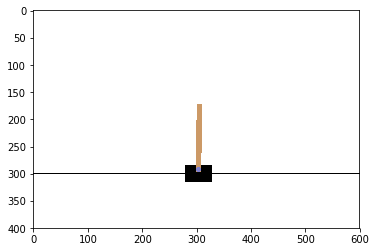

In [3]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))


够着一个简单的网络表示q-table
- 网络的输入为状态s，输出为q(s,a),输出神经元的数量等于action的数量

todo:
- 基于keras实现，两层的全连接网络，hidden_size，分别是[100,100,action_num]
- 不用激励函数。
- 实现get_action(state, network, epsilon=0)
- network如何训练？训练数据？

In [9]:
import keras
from keras import layers
network = keras.models.Sequential()
state_dim = 10
action_num = 4

network.add(layers.Dense(units=128, activation='relu', input_dim=state_dim))
network.add(layers.Dense(units=128, activation='relu'))
network.add(layers.Dense(units=action_num))
network.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])


In [0]:
import numpy as np
import random
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state)[0]
    
    ###YOUR CODE
    best_action = np.argmax(np.array(q_values))
    random_action = random.choice(list(range(len(q_values))))
    random.choice([True, False],p)

    return <epsilon-greedily selected action>